In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
import gc
from keras.models import Model
from keras.layers import Dense, Conv1D, Dropout, Input, GlobalAveragePooling1D, MaxPool1D, Flatten, LSTM

In [13]:
questions = pd.read_csv('./train.csv')
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [14]:
questions.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [15]:
questions['lengths'] = questions.question_text.apply(len)

In [16]:
round(questions.target.value_counts()[1]*100/(questions.target.value_counts()[1] + questions.target.value_counts()[0]),2)

6.19

### Hypothesis - Slightly longer texts are insincere

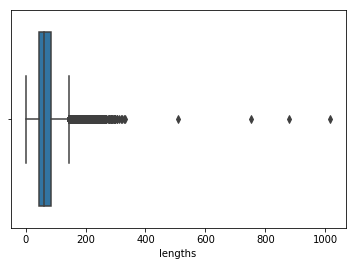

In [17]:
sns.boxplot(questions.lengths)

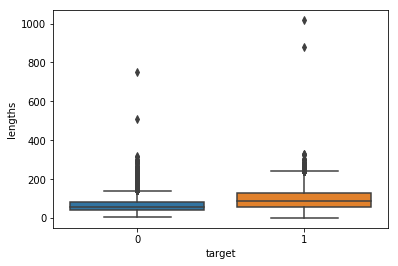

In [18]:
sns.boxplot(data=questions, x = 'target', y = 'lengths')

In [19]:
questions[['target','lengths']].groupby('target').median()

,lengths
target,
0,59
1,86


In [20]:
# max_len = max(questions.lengths)
max_len = 200

### Embeddings

In [21]:
embeddings = dict()
file = open('./glove.840B.300d/glove.840B.300d.txt', encoding='UTF-8')
for line in file:
    values = line.split(" ")
    word, coefs  = values[0], np.array(values[1:], dtype='float32')
    embeddings[word] = coefs

In [22]:
tkn = Tokenizer()
tkn.fit_on_texts(questions.question_text)
vocab_size = len(tkn.word_index) + 1
enc_sentence = tkn.texts_to_sequences(questions.question_text)
enc_sentence = pad_sequences(enc_sentence, max_len)

In [23]:
embed_matrix = np.zeros((vocab_size, 300))
for word, i in tkn.word_index.items():
    vec = embeddings.get(word)
    if(vec is not None):
        embed_matrix[i] = vec

In [25]:
sent_vecs = np.zeros((len(enc_sentence), 300))
for i in range(len(enc_sentence)):
    word_vec = np.array([embed_matrix[w] for w in enc_sentence[i]])
    sent_vec = np.sum(word_vec, axis=0)
    sent_vec = sent_vec/sqrt((sent_vec**2).sum())
    sent_vec = np.nan_to_num(sent_vec)
    # sent_vec = sent_vec.reshape((300, 1))
    sent_vecs[i] = sent_vec
sent_vecs.shape

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


(1306122, 300)

In [26]:
np.isfinite(sent_vecs).any(), np.isnan(sent_vecs).any()

(True, False)

In [29]:
gc.collect()

0

In [110]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_sample(sent_vecs, questions.target)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size = 0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(sent_vecs, questions.target, 
#                                                    test_size = 0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((129296, 300, 1), (32324, 300, 1), (129296,), (32324,))

In [111]:
gc.collect()

5388

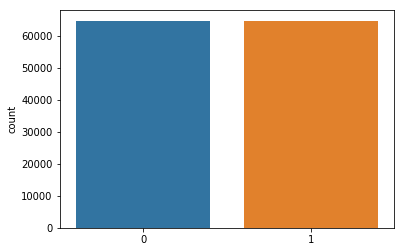

In [112]:
sns.countplot(y_train)

In [75]:
## conv neural net

In [117]:
inputs = Input(shape=[300, 1])

conv = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
conv = MaxPool1D(pool_size=2)(conv)

conv = Conv1D(filters=128, kernel_size=3, activation='relu')(conv)
conv = MaxPool1D(pool_size=2)(conv)

conv = Conv1D(filters=256, kernel_size=3, activation='relu')(conv)
conv = MaxPool1D(pool_size=2)(conv)

conv = LSTM(20)(conv)
# conv = Flatten()(conv)
# conv = GlobalAveragePooling1D()(conv)

dense = Dense(64, activation='relu')(conv)
# dense = Dense(32, activation='relu')(dense)
dense = Dense(1, activation='sigmoid')(dense)

nn_conv = Model(inputs=inputs, outputs=dense)
nn_conv.summary()

nn_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 300, 1)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 296, 64)           384       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 148, 64)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 146, 128)          24704     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 73, 128)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 71, 256)           98560     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 35, 256)           0         
__________

In [118]:
performance = nn_conv.fit(X_train, y_train, 
                          batch_size=128, epochs=5, 
                          validation_data=[X_test, y_test])

Train on 129296 samples, validate on 32324 samples
Epoch 1/5
129296/129296 [==============================] - 111s - loss: 0.6930 - acc: 0.5177 - val_loss: 0.6929 - val_acc: 0.5847

In [119]:
preds = nn_conv.predict(X_test)

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


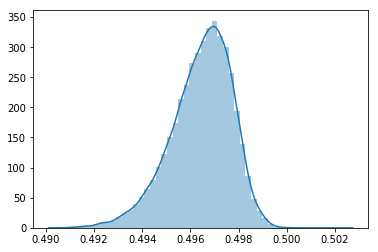

In [120]:
sns.distplot(preds)

In [127]:
preds_bin = [0 if i<0.496 else 1 for i in preds]

In [128]:
f1_score(y_pred=preds_bin, y_true=y_test)

0.6904599211563731

## Submission

In [53]:
questions_test = pd.read_csv('./test.csv')
questions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56370 entries, 0 to 56369
Data columns (total 2 columns):
qid              56370 non-null object
question_text    56370 non-null object
dtypes: object(2)
memory usage: 880.9+ KB


In [54]:
enc_sentence_test = tkn.texts_to_sequences(questions_test.question_text)
enc_sentence_test = pad_sequences(enc_sentence_test, max_len)
len(enc_sentence_test)

56370

In [55]:
sent_vecs_test = np.zeros((len(enc_sentence_test), 300))
for i in range(len(enc_sentence_test)):
    word_vec = np.array([embed_matrix[w] for w in enc_sentence_test[i]])
    sent_vec = np.sum(word_vec, axis=0)
    sent_vec = sent_vec/sqrt((sent_vec**2).sum())
    sent_vec = np.nan_to_num(sent_vec)
    # sent_vec = sent_vec.reshape((300, 1))
    sent_vecs_test[i] = sent_vec
sent_vecs_test.shape

(56370, 300)

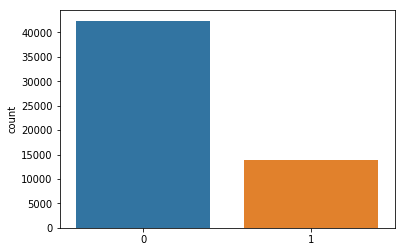

In [57]:
preds = nn_conv.predict(sent_vecs_test.reshape((56370, 300, 1)))
preds = [0 if i<0.51 else 1 for i in preds]
sns.countplot(preds)

In [58]:
submission = pd.DataFrame({'qid': questions_test.qid, 'prediction':preds})
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56370 entries, 0 to 56369
Data columns (total 2 columns):
prediction    56370 non-null int64
qid           56370 non-null object
dtypes: int64(1), object(1)
memory usage: 880.9+ KB


In [59]:
submission.to_csv('./submission.csv', index=False)